In [1]:
from binance.client import Client
import pandas as pd

API_KEY = 'plGnPKANetCu4LAzt9Bwp3OFj6inSTSbhc1iVoEpItGSoeDm18Rszmruek50qPfS'
API_SECRET = 'h9Hh1BCObXSCmNg4AtFQto81V5msxw4vLNO4TOMgdX9XYrkWbWZ8xzCTFi4bK7zX'
client = Client(API_KEY, API_SECRET)

In [2]:
def binanceDataFrame(klines):
    df = pd.DataFrame(klines,dtype=float, columns = ('Open Time',
                                                                    'open',
                                                                    'high',
                                                                    'low',
                                                                    'close',
                                                                    'volume',
                                                                    'Close time',
                                                                    'Quote asset volume',
                                                                    'Number of trades',
                                                                    'Taker buy base asset volume',
                                                                    'Taker buy quote asset volume',
                                                                    'Ignore'))

    df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
    df = df.set_index('Open Time')
    
    return df

new_date_load = False
if new_date_load:
    candlesticks = client.get_historical_klines("XRPUSDT", Client.KLINE_INTERVAL_5MINUTE, '2 years')#"31 Aug, 2021", "1 Sep, 2021")
    df = binanceDataFrame(candlesticks)
else:
    
    df = pd.read_csv("xrp_sincejan5min.csv")
    df['Open Time'] = pd.to_datetime(df['Open Time'])
    df = df.set_index('Open Time')



In [3]:
# df.to_csv("xrp_2year.csv")

In [4]:
import backtrader as bt
import datetime as dt

import backtrader as bt
import backtrader.indicators as btind

# #Add data feed to Cerebro
data = bt.feeds.PandasData(dataname=df)


In [5]:
from sklearn.linear_model import LinearRegression


In [6]:
def printTradeAnalysis(cerebro, analyzers):
    print('Backtesting Results')
    if hasattr(analyzers, 'ta'):
        ta = analyzers.ta.get_analysis()

        openTotal         = ta.total.open          
        closedTotal       = ta.total.closed        
        wonTotal          = ta.won.total           
        lostTotal         = ta.lost.total          

        streakWonLongest  = ta.streak.won.longest  
        streakLostLongest = ta.streak.lost.longest 

        pnlNetTotal       = ta.pnl.net.total       
        pnlNetAverage     = ta.pnl.net.average     

        print('Open Positions', openTotal  )
        print('Closed Trades',  closedTotal)
        print('Winning Trades', wonTotal   )
        print('Loosing Trades', lostTotal  )
       

        print('Longest Winning Streak',   streakWonLongest )
        print('Longest Loosing Streak',   streakLostLongest)
        print('Strike Rate (Win/closed)', (wonTotal / closedTotal) * 100 if wonTotal and closedTotal else 0)
        

#         print(format, 'Inital Portfolio Value', '${}'.format(100))
        print( 'Final Portfolio Value',  '${}'.format(cerebro.broker.getvalue()))
        print( 'Net P/L',                '${}'.format(round(pnlNetTotal,   2)) )
        print( 'P/L Average per trade',  '${}'.format(round(pnlNetAverage, 2)))
        print('\n')

    if hasattr(analyzers, 'drawdown'):
        print('Drawdown', '${}'.format(analyzers.drawdown.get_analysis()['drawdown']))
    if hasattr(analyzers, 'sharpe'):
        print( 'Sharpe Ratio:', analyzers.sharpe.get_analysis()['sharperatio'])
    if print(analyzers, 'vwr'):
        print( 'VRW', analyzers.vwr.get_analysis()['vwr'])
    if hasattr(analyzers, 'sqn'):
        print( 'SQN', analyzers.sqn.get_analysis()['sqn'])
    print('\n')

    print('Transactions')
    print( 'Date', 'Amount', 'Price', 'SID', 'Symbol', 'Value')
    for key, value in analyzers.txn.get_analysis().items():
        print( key.strftime("%Y/%m/%d %H:%M:%S"), value[0][0], value[0][1], value[0][2], value[0][3], value[0][4])


In [7]:
"""
Defines class / functions tools for strategies.
"""
import backtrader as bt



In [8]:

class firstStrategy(bt.Strategy):
    params = (
        ('rsi_period',21),
        ('fast_rsi_period',8),
        ('ema_period',13),
        ('stop_loss',1),
        ('ema1',20),
        ('ema2',50),
        ('ema3',200),

    )
    def __init__(self):
        self.startcash = self.broker.getvalue()
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.rsi_fast = bt.indicators.RSI(self.data.close, period=8)
        self.ema1 = bt.indicators.EMA(self.data.close, period=self.params.ema1) 
        self.ema2 = bt.indicators.EMA(self.data.close, period=self.params.ema2) 

        self.ema3 = bt.indicators.EMA(self.data.close, period=self.params.ema3) 


        self.o_li = list()

        # To keep track of pending orders
        self.order = None  
        self.stopOrder = None

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
#         dt = dt or self.datas[0].datetime.datetime(0)
# #         print('%s, %s' % (dt.isoformat(), txt))
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

#         self.log("OPERATION PROFIT, GROSS %.2f, NET %.2f" % (trade.pnl, trade.pnlcomm))
        

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash

        if order.status in [order.Completed]:
#             if order.isbuy():
#                 self.log(f'BUY EXECUTED, {order.executed.price:.5f}')
# #                 stop_price = order.executed.price * (1.0 - self.params.stop_loss)
# #                 self.sell(exectype=bt.Order.Stop, price=stop_price)
#             elif order.issell():
#                 self.log(f'SELL EXECUTED, {order.executed.price:.5f}')
#                 self.log
            self.bar_executed = len(self)

        
    def next(self):

        if not self.position:
            if self.rsi<30 and self.ema2>self.ema3:
                size = 1000/self.datas[0].close[0]

                self.order = self.buy(price=(self.datas[0].close[0]),exectype=bt.Order.Market,size=size)
#             if self.rsi>70 and self.order.Completed:
#                 self.order = self.sell(price=(self.datas[0].close[0]),exectype=bt.Order.Market,size=1000)

        else:
            if self.order and (self.data.close - self.order.price)!=0.0:
                change = (self.data.close - self.order.price)/self.order.price
                if change>0.04 or change<-0.02:
#                     print("selling at change:", change)
                    self.sell()

    def stop(self):
        pnl = round(self.broker.getvalue() - 2000,2)
        print('RSI Period: {} EMA1: {} EMA2 : {} EMA3: {} Final PnL: {}'.format(
            self.params.rsi_period, self.params.ema1,self.params.ema2,self.params.ema3,pnl))

In [9]:
import backtrader as bt
from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo
# ======================================================================================================================
# MAIN
# ======================================================================================================================

# Create an instance of cerebro
cerebro = bt.Cerebro(stdstats=False)

# Be selective about what we chart
#cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.addobserver(bt.observers.Trades)

# Set the investment capital
cerebro.broker.setcash(2000)
cerebro.broker.setcommission(.001)

# Set position size
cerebro.addsizer(bt.sizers.PercentSizer, percents=100)

# Add our strategy
cerebro.addstrategy(firstStrategy , rsi_period=14, ema1 = (20),ema2 = (100), ema3 = (200))
# cerebro.optstrategy(firstStrategy, rsi_period=6)

cerebro.adddata(data)


# Add analyzers
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='ta')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.0, annualize=True, timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.VWR, _name='vwr')
cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
cerebro.addanalyzer(bt.analyzers.Transactions, _name='txn')
# # Run our Backtest
backtest = cerebro.run()
backtest_results = backtest[0]



Loading BokehJS ...

RSI Period: 14 EMA1: 20 EMA2 : 100 EMA3: 200 Final PnL: 1236.54


<IPython.core.display.Javascript object>


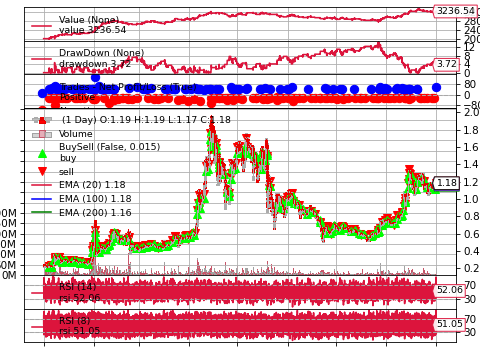

In [10]:
figure = cerebro.plot(style ='candlebars')[0][0]
figure.savefig('example.png')

In [11]:
printTradeAnalysis(cerebro,backtest_results.analyzers)

Backtesting Results
Open Positions 0
Closed Trades 214
Winning Trades 101
Loosing Trades 113
Longest Winning Streak 5
Longest Loosing Streak 7
Strike Rate (Win/closed) 47.19626168224299
Final Portfolio Value $3236.5415389485556
Net P/L $1236.54
P/L Average per trade $5.78


Drawdown $3.721947803578348
Sharpe Ratio: 2.7664521833118174
<backtrader.metabase.ItemCollection object at 0x000001CA69F52F10> vwr
SQN 2.272601189850213


Transactions
Date Amount Price SID Symbol Value
2021/01/04 09:35:00 4409.948844593403 0.22648000000000001 0  -998.765214323514
2021/01/04 10:15:00 -4409.948844593403 0.22171 0  977.7297583348034
2021/01/04 10:20:00 4509.37950937951 0.22124000000000002 0  -997.6551226551228
2021/01/04 11:55:00 -4509.37950937951 0.23106 0  1041.9372294372295
2021/01/05 04:00:00 4389.430251953297 0.22775 0  -999.6927398823633
2021/01/05 11:15:00 -4389.430251953297 0.23799 0  1044.640505662365
2021/01/05 14:05:00 4367.765887748417 0.22894 0  -999.9563223411227
2021/01/05 14:10:00 -436

2021/06/15 02:00:00 1140.2508551881415 0.877 0  -1000.0000000000001
2021/06/15 15:05:00 -1140.2508551881415 0.8594 0  979.9315849486889
2021/06/17 12:15:00 1182.4524062906469 0.8458 0  -1000.1182452406291
2021/06/17 18:10:00 -1182.4524062906469 0.8286 0  979.78006385243
2021/06/21 01:45:00 1328.9036544850499 0.7525 0  -1000.0
2021/06/21 02:45:00 -1328.9036544850499 0.7374 0  979.9335548172759
2021/06/21 02:50:00 1354.0961408259986 0.7385 0  -1000.0000000000001
2021/06/21 04:05:00 -1354.0961408259986 0.7236 0  979.8239675016927
2021/06/23 15:15:00 1599.2323684631378 0.6252 0  -999.8400767631538
2021/06/23 19:45:00 -1599.2323684631378 0.6103 0  976.0115144730529
2021/06/23 19:55:00 1653.9861065167051 0.6046 0  -1000.0
2021/06/23 21:20:00 -1653.9861065167051 0.634 0  1048.627191531591
2021/06/25 01:05:00 1520.2189115232593 0.6579999999999999 0  -1000.3040437823045
2021/06/25 02:15:00 -1520.2189115232593 0.6849 0  1041.1979325022803
2021/06/25 07:20:00 1539.1719255040787 0.6497 0  -1000.0


In [12]:
# cerebro.optstrategy(firstStrategy,  rsi_period=14, ema1 = (10,20),ema2 = (50,100), ema3 = (200))
# opt_runs = cerebro.run(maxcpus = 1)

# # Generate results list
# final_results_list = []
# for run in opt_runs:
#     for strategy in run:
#         value = round(strategy.broker.get_value(),2)
#         PnL = round(value - startcash,2)
#         period = strategy.params.period
#         final_results_list.append([period,PnL])

# #Sort Results List
# by_period = sorted(final_results_list, key=lambda x: x[0])
# by_PnL = sorted(final_results_list, key=lambda x: x[1], reverse=True)

# #Print results
# print('Results: Ordered by period:')
# for result in by_period:
#     print('Period: {}, PnL: {}'.format(result[0], result[1]))
# print('Results: Ordered by Profit:')
# for result in by_PnL:
#     print('Period: {}, PnL: {}'.format(result[0], result[1]))